# Memes vs Notes
Memes vs Notes is a binary classifier which classifies an image on the basis of its feature and tells us if it's a meme or a note. An image when passed to the trained model gets classified according to its content. If the image belongs to neither of the two classes then it will classify it in any one of it.
- Here we use a convolutional neural network to classify the images

### Importing libraries
**1) Libraries for preprocessing**
- PIL : PIL is the Python Imaging Library by Fredrik Lundh and Contributors. The library supports a wide variety of image file formats. Click [here](https://pillow.readthedocs.io/en/stable/) to read more about PIL.
- Image : The Image module provides a class with the same name which is used to represent a PIL image. The module also provides a number of factory functions, including functions to load images from files, and to create new images. Click [here](https://pillow.readthedocs.io/en/stable/reference/Image.html) to read more about Image
- numpy : Numpy is the core library for scientific computing in Python. It provides a high-performance multidimensional array object, and tools for working with these arrays
- os : This module provides a portable way of using operating system dependent functionality. Click [here](https://docs.python.org/3/library/os.html) to read more about it. For our program we will use to iterate in images in a folder

In [1]:
import PIL
from PIL import Image
import numpy as np
import os

**2)Libraries for training our model**
- torch : PyTorch is a Python package that provides two high-level features:
  1. Tensor computation (like NumPy) with strong GPU acceleration
  1. Deep neural networks built on a tape-based autograd system

To read more about pytorch, click on [pytorch](https://github.com/pytorch/pytorch) to access the github repsitory

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Preprocessing
 - If using stage_0 data then run the code below. Copy the location of memes and notes respectively and use it in directory for preprocessing. This block of code will convert all the images to .jpg format and resize them to a size of (256 * 256 * 3). After that it will rename and save the images in the specified folder.

In [3]:
'''directory = r'C:/Users/tpath/Desktop/Stage_0/Memes'        #location of meme folder
i = 0
for filename in os.listdir(directory):                        #iterate over images in memes folder
    i = i+1
    img = Image.open('C:/Users/tpath/Desktop/Stage_0/Memes/'+filename)      # Storing image in variable named (img)
    rimg = img.resize((256,256))                                            # Resizing. You can choose other dimensions
    rimg.save('C:/Users/tpath/Desktop/Stage_1/Memes/'+str(i)+'.jpg')        # Saving images. first string is the location where
                                                                            # where you want to save your image. 
                                                                            # Second string is the name of the image that you 
                                                                            # want to save.
                                                                            # Third string is the extension
del img,rimg'''

"directory = r'C:/Users/tpath/Desktop/Stage_0/Memes'        #location of meme folder\ni = 0\nfor filename in os.listdir(directory):                        #iterate over images in memes folder\n    i = i+1\n    img = Image.open('C:/Users/tpath/Desktop/Stage_0/Memes/'+filename)      # Storing image in variable named (img)\n    rimg = img.resize((256,256))                                            # Resizing. You can choose other dimensions\n    rimg.save('C:/Users/tpath/Desktop/Stage_1/Memes/'+str(i)+'.jpg')        # Saving images. first string is the location where\n                                                                            # where you want to save your image. \n                                                                            # Second string is the name of the image that you \n                                                                            # want to save.\n                                                                            # Third string 

In [4]:
'''directory = r'C:/Users/tpath/Desktop/Stage_0/Notes'
i = 0
for filename in os.listdir(directory):
    i = i+1
    img = Image.open('C:/Users/tpath/Desktop/Stage_0/Notes/'+filename)
    rimg = img.resize((256,256))
    rimg.save('C:/Users/tpath/Desktop/Stage_1/Notes/'+str(i)+'.jpg')
    del img,rimg'''

"directory = r'C:/Users/tpath/Desktop/Stage_0/Notes'\ni = 0\nfor filename in os.listdir(directory):\n    i = i+1\n    img = Image.open('C:/Users/tpath/Desktop/Stage_0/Notes/'+filename)\n    rimg = img.resize((256,256))\n    rimg.save('C:/Users/tpath/Desktop/Stage_1/Notes/'+str(i)+'.jpg')\n    del img,rimg"

- There is a folder provided named as Stage_1. It contains preprocessed data. No need to run above two blocks of code if using Stage_1 data. Following block contains code which load our data and label it and store it as our dataset.

   **Note:- The following code will create a unshuffled image data i.e. The first 800 images are memes and next 800 are notes**

In [5]:
directory = r'C:/Users/tpath/Desktop/Stage_1/Memes/' #Location of preprocessed memes images
imgs = []
for filename in os.listdir(directory):               #Iterate over images
    img = Image.open(directory + filename)
    img = np.array(img)                              #Convert images to numpy arrays
    img = np.rollaxis(img,2)                         #This function will convert (256*256*3) into (3*256*256) images.
                                                     #Its important because pytorch m=module accept images in second format only
    img = [img , 1]                                  #Labeling images {1 for memes}
    imgs.append(img)
directory = r'C:/Users/tpath/Desktop/Stage_1/Notes/' #Location of preprocessed notes images
for filename in os.listdir(directory):
    img = Image.open(directory + filename)
    img = np.array(img)
    img = np.rollaxis(img,2)
    img = [img , 0]                                  ##Labeling images {0 for notes}
    imgs.append(img)

### Dividing the image set -
- Dividing the image set into 3 sets:
 1. Train set with 1500 examples
 1. Test set with 50 examples
 1. Val set with 50 example
 
**Note:- The training set must be balanced otherwise the model will bias towards one of the class**

In [6]:
train_set = imgs[0:750] + imgs[800:1550]
test_set = imgs[750:775] + imgs[1550:1575]
val_set = imgs[775:800] + imgs[1575:1600]
np.random.shuffle(train_set)
np.random.shuffle(test_set)
np.random.shuffle(val_set)

### Dataloader -
- For better training of the model, we pass our train_set in the following function. The batch_maker function creates batches of specified length and store them in an array named loader_set. If no batch size is specified, 1 is selected and weights are updated after every iteration

In [7]:
def batch_maker(t_set, batch_size=1):
    loader_set = []
    for i in range(0,len(t_set),batch_size):
        t_data = []
        t_label = []
        for j in range(batch_size):
            t_data.append(t_set[i+j][0])
            t_label.append(t_set[i+j][1])
        loader_set.append([t_data , t_label])
    return loader_set

## Class for Training model - 
We use pytorch's nn library to make a class that will feed forward our input data while keeping track on the weight tensors and biases.

**1) Convolutional Neural Network model - Network1**  
**2) Linear Layer Neural Network model  - Network2** 

In [8]:
class Network1(nn.Module):
    def __init__(self):
        super(Network1, self).__init__()                                          # Inheriting all atrributes and methods from module base class
        self.conv1 = nn.Conv2d(in_channels=3 , out_channels=8 , kernel_size=7)   # Creating Convolutional layer 1
        self.conv2 = nn.Conv2d(in_channels=8 , out_channels=16 , kernel_size=6)  # Creating Convolutional layer 2
        
        self.fc1 = nn.Linear(in_features=16*60*60 , out_features=50 , bias=True) # Creating dense layer 1
        self.fc2 = nn.Linear(in_features=50 , out_features=20 , bias=True)       # Creating dense layer 2
        self.fc3 = nn.Linear(in_features=20 , out_features=2 , bias=True)        # Creating dense layer 3
    
    def forward(self, t):
        
        t = self.conv1(t)                               # Implementing Convolutional layer 1
        t = F.relu(t)
        t = F.max_pool2d(t ,kernel_size=2 ,stride=2)
        
        t = self.conv2(t)                               # Implementing Convolutional layer 2
        t = F.relu(t)
        t = F.max_pool2d(t ,kernel_size=2 ,stride=2)
        
        t = t.reshape(-1,16*60*60)                      # Implementing dense layer 1
        t = self.fc1(t)
        t = F.relu(t)
        
        t = self.fc2(t)                                 # Implementing dense layer 2
        t = F.relu(t)
        
        t = self.fc3(t)                                 # Implementing dense layer 3
        return t

In [9]:
class Network2(nn.Module):
    def __init__(self):
        super(Network2, self).__init__()                                          # Inheriting all atrributes and methods from module base class
        
        self.fc1 = nn.Linear(in_features=3*256*256 , out_features=300 , bias=True) # Creating dense layer 1
        self.fc2 = nn.Linear(in_features=300 , out_features=100 , bias=True)       # Creating dense layer 2
        self.fc3 = nn.Linear(in_features=100 , out_features=2 , bias=True)        # Creating dense layer 3
    
    def forward(self, t):
        
        t = t.reshape(-1,3*256*256)                      # Implementing dense layer 1
        t = self.fc1(t)
        t = F.relu(t)
        
        t = self.fc2(t)                                 # Implementing dense layer 2
        t = F.relu(t)
        
        t = self.fc3(t)                                 # Implementing dense layer 3
        return t

### Functions which are necessary to for us to analyse model
- get_num_correct(preds, labels) : This function returns the number of correct output
- testing(tset) : This function returns accuracy in percentage of any set that is passed through it

In [10]:
def get_num_correct(preds, labels):                      #Returns number of correct outputs
    return preds.argmax(dim=1).eq(labels).sum().item()

In [11]:
def testing(tset):                                    #This function returns total number of correctly classified outputs
    batch_set = batch_maker(tset, len(tset))
    images,labels = next(iter(batch_set))
    images = torch.tensor(images, dtype=torch.float32)
    images = images/256
    labels = torch.tensor(labels)
    total_correct = 0
    preds = network(images)
    preds = F.softmax(preds, dim=1)
    total_correct += get_num_correct(preds, labels)
    return total_correct

## Creating an instance of out Network class and training our model - 
Following code will train our model and give us the number of correctly classified outputs:

### Network1 :-

In [12]:
network = Network1()
network = network.cuda()
optimizer = optim.Adam(network.parameters(), lr=0.002)

In [13]:
batch_set = batch_maker(train_set, 20)
loss_track = []
correct_track = []
epoch_num = []
for epoch in range(5):
    epoch_num.append(epoch)
    total_loss = 0
    total_correct = 0

    for batch in batch_set: # Get Batch
        
        images, labels = batch
        images = torch.tensor(images, dtype = torch.float32)
        images = images/256             #normalizing
        images = images.cuda()
        labels = torch.tensor(labels)
        labels = labels.cuda()

        preds = network(images)               # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward()  # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)
        
    loss_track.append(total_loss)
    correct_track.append(total_correct)
    
    print("epoch", epoch, " train_set total_correct:", total_correct/(len(train_set)*0.01),'%', "loss:", total_loss)
    
    network = network.cpu()
    print('\t    val_set', testing(val_set)/(len(val_set)*0.01),'%')
    testing(val_set)
    print('\t   test_set', testing(test_set)/(len(test_set)*0.01),'%')
    network = network.cuda()

epoch 0  train_set total_correct: 80.06666666666666 % loss: 43.050577275455
	    val_set 84.0 %
	   test_set 84.0 %
epoch 1  train_set total_correct: 77.13333333333334 % loss: 37.763400349766016
	    val_set 50.0 %
	   test_set 50.0 %
epoch 2  train_set total_correct: 86.13333333333334 % loss: 27.11660135537386
	    val_set 96.0 %
	   test_set 94.0 %
epoch 3  train_set total_correct: 96.86666666666666 % loss: 13.700265852734447
	    val_set 92.0 %
	   test_set 96.0 %
epoch 4  train_set total_correct: 98.0 % loss: 6.110912315547466
	    val_set 98.0 %
	   test_set 98.0 %


## Analysing our model-
- matplotlib .pyplot helps us to plot graph between variables with ease

In [14]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'total loss')

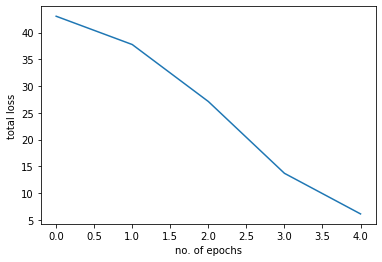

In [15]:
plt.plot(epoch_num, loss_track)
plt.xlabel('no. of epochs')
plt.ylabel('total loss')

Text(0, 0.5, 'correct output ')

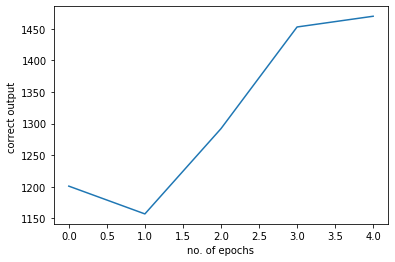

In [16]:
plt.plot(epoch_num, correct_track)
plt.xlabel('no. of epochs')
plt.ylabel('correct output ')

### Network2 :-

In [19]:
network = Network2()
network = network.cuda()
optimizer = optim.Adam(network.parameters(), lr=0.002)

In [20]:
batch_set = batch_maker(train_set, 20)
loss_track = []
correct_track = []
epoch_num = []
for epoch in range(5):
    epoch_num.append(epoch)
    total_loss = 0
    total_correct = 0

    for batch in batch_set: # Get Batch
        
        images, labels = batch
        images = torch.tensor(images, dtype = torch.float32)
        images = images/256            #normalizing
        images = images.cuda()
        labels = torch.tensor(labels)
        labels = labels.cuda()

        preds = network(images)               # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward()  # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)
        
    loss_track.append(total_loss)
    correct_track.append(total_correct)
    
    print("epoch", epoch, " train_set total_correct:", total_correct/(len(train_set)*0.01),'%', "loss:", total_loss)
    
    network = network.cpu()
    print('\t    val_set', testing(val_set)/(len(val_set)*0.01),'%')
    testing(val_set)
    print('\t   test_set', testing(test_set)/(len(test_set)*0.01),'%')
    network = network.cuda()

epoch 0  train_set total_correct: 63.93333333333333 % loss: 508.74907456338406
	    val_set 72.0 %
	   test_set 70.0 %
epoch 1  train_set total_correct: 79.66666666666667 % loss: 65.74041526578367
	    val_set 80.0 %
	   test_set 88.0 %
epoch 2  train_set total_correct: 85.93333333333334 % loss: 26.47014795988798
	    val_set 74.0 %
	   test_set 84.0 %
epoch 3  train_set total_correct: 88.26666666666667 % loss: 21.899101354181767
	    val_set 76.0 %
	   test_set 92.0 %
epoch 4  train_set total_correct: 91.53333333333333 % loss: 15.942076412960887
	    val_set 82.0 %
	   test_set 94.0 %


## Analysing our model-
- matplotlib .pyplot helps us to plot graph between variables with ease

Text(0, 0.5, 'total loss')

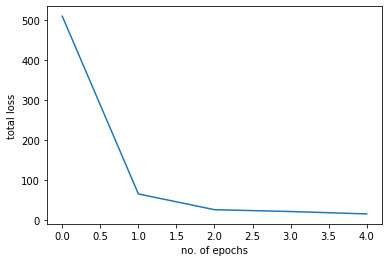

In [24]:
plt.plot(epoch_num, loss_track)
plt.xlabel('no. of epochs')
plt.ylabel('total loss')

Text(0, 0.5, 'correct output ')

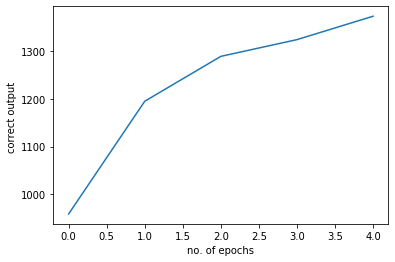

In [25]:
plt.plot(epoch_num, correct_track)
plt.xlabel('no. of epochs')
plt.ylabel('correct output ')